In [ ]:
import os
import shutil

base_dir = "/content/tiny-imagenet-200"
val_dir = os.path.join(base_dir, "val")
images_dir = os.path.join(val_dir, "images")
ann_file = os.path.join(val_dir, "val_annotations.txt")

# Read annotations
with open(ann_file) as f:
    annotations = [line.strip().split('\t') for line in f]

# Create class folders and move images
for img, cls, *_ in annotations:
    cls_dir = os.path.join(val_dir, cls)
    os.makedirs(cls_dir, exist_ok=True)
    shutil.move(
        os.path.join(images_dir, img),
        os.path.join(cls_dir, img)
    )

os.rmdir(images_dir)

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfla
import tensorflow.keras.models as tfm
import tensorflow.keras.optimizers as tfo
import tensorflow.keras.losses as tflo
import matplotlib.pyplot as plt

In [ ]:
# load training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/tiny-imagenet-200/train",
    image_size=(256, 256),
    batch_size=None,
    label_mode="int"
)

# load test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/tiny-imagenet-200/val",
    image_size=(256, 256),
    batch_size=None,
    label_mode="int"
)

Found 100000 files belonging to 200 classes.
Found 10000 files belonging to 200 classes.


In [ ]:
def crop_image(image, target_height=224, target_width=224):
  image = tf.image.random_crop(image, size=[target_height, target_width, 3])
  image = tf.image.random_flip_left_right(image)
  return image

In [ ]:
train_ds = train_ds.map(lambda x, y : (crop_image(x), y))
test_ds = test_ds.map(lambda x, y : (crop_image(x), y))

In [ ]:
train_ds = train_ds.batch(128)
test_ds = test_ds.batch(128)

In [ ]:
for images, _ in train_ds.take(1):
  print(images.shape)

(128, 224, 224, 3)


In [ ]:
def find_per_channel_mean(dataset):
  total = tf.zeros([3], dtype = tf.float32)
  count = 0

  for images, _ in dataset.take(20):
    pixels = tf.reshape(images, [-1, 3])
    total += tf.reduce_sum(pixels, axis=0)
    count += tf.shape(pixels)[0]

  return(total / tf.cast(count, dtype=tf.float32))

In [ ]:
print(find_per_channel_mean(train_ds))

tf.Tensor([122.02211 114.00226  99.76855], shape=(3,), dtype=float32)


In [ ]:
mean = find_per_channel_mean(train_ds)
train_ds = train_ds.map(lambda x, y : (x - mean, y))
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y : (x - mean, y))
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
def inception_module(x, channels1, channels21, channels22, channels31,
                     channels32, channels42):
  b1 = tfla.Conv2D(channels1, 1, padding="same", activation="relu",
                   kernel_initializer=tf.keras.initializers.HeNormal(),
                   use_bias=False)(x)
  b1 = tfla.BatchNormalization()(b1)
  b1 = tfla.ReLU()(b1)

  b2 = tfla.Conv2D(channels21, 1, padding="same", activation="relu",
                   kernel_initializer=tf.keras.initializers.HeNormal(),
                   use_bias=False)(x)
  b2 = tfla.BatchNormalization()(b2)
  b2 = tfla.ReLU()(b2)
  b2 = tfla.Conv2D(channels22, 3, padding="same", activation="relu",
                   kernel_initializer=tf.keras.initializers.HeNormal(),
                   use_bias=False)(b2)
  b2 = tfla.BatchNormalization()(b2)
  b2 = tfla.ReLU()(b2)

  b3 = tfla.Conv2D(channels31, 1, padding="same", activation="relu",
                   kernel_initializer=tf.keras.initializers.HeNormal(),
                   use_bias=False)(x)
  b3 = tfla.BatchNormalization()(b3)
  b3 = tfla.ReLU()(b3)
  b3 = tfla.Conv2D(channels32, 5, padding="same", activation="relu",
                   kernel_initializer=tf.keras.initializers.HeNormal(),
                   use_bias=False)(b3)
  b3 = tfla.BatchNormalization()(b3)
  b3 = tfla.ReLU()(b3)

  b4 = tfla.MaxPool2D(3, 1, padding="same")(x)
  b4 = tfla.Conv2D(channels42, 1, padding="same", activation="relu",
                   kernel_initializer=tf.keras.initializers.HeNormal(),
                   use_bias=False)(b4)
  b4 = tfla.BatchNormalization()(b4)
  b4 = tfla.ReLU()(b4)

  return(tfla.concatenate([b1, b2, b3, b4]))

In [ ]:
# auxiliary classifier can be used by we already have BN doing the job.
# So, we don't use it
def auxiliary_classifier(x, name):
  x = tfla.AveragePooling2D(5, 3, padding="valid")(x)
  x = tfla.Conv2D(128, 1, padding="same", activation="relu")(x)
  x = tfla.Flatten()(x)
  x = tfla.Dense(1024, activation="relu")(x)
  x = tfla.Dropout(0.7)(x)
  x = tfla.Dense(200, name=name)(x)
  return(x)

In [ ]:
inputs = tfla.Input(shape=(224, 224, 3))

x = tfla.Conv2D(64, 7, strides=2, padding="same",
                   kernel_initializer=tf.keras.initializers.HeNormal(),
                   use_bias=False)(inputs)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.MaxPool2D(pool_size=3, strides=2, padding="same")(x)

x = tfla.Conv2D(64, 1, strides=1, padding="same",
                   kernel_initializer=tf.keras.initializers.HeNormal(),
                   use_bias=False)(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)

x = tfla.Conv2D(192, 3, strides=1, padding="same",
                   kernel_initializer=tf.keras.initializers.HeNormal(),
                   use_bias=False)(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.MaxPool2D(pool_size=3, strides=2, padding="same")(x)

# inception 3
x = inception_module(x, 64, 96, 128, 16, 32, 32)
x = inception_module(x, 128, 128, 192, 32, 96, 64)
x = tfla.MaxPool2D(pool_size=3, strides=2, padding="same")(x)

# inception 4
x = inception_module(x, 192, 96, 208, 16, 48, 64)
aux1 = auxiliary_classifier(x, "aux1")
x = inception_module(x, 160, 112, 224, 24, 64, 64)
x = inception_module(x, 128, 128, 256, 24, 64, 64)
x = inception_module(x, 112, 144, 288, 32, 64, 64)
aux2 = auxiliary_classifier(x, "aux2")
x = inception_module(x, 256, 160, 320, 32, 128, 128)
x = tfla.MaxPool2D(pool_size=3, strides=2, padding="same")(x)

# inception 5
x = inception_module(x, 256, 160, 320, 32, 128, 128)
x = inception_module(x, 384, 192, 384, 48, 128 ,128)

x = tfla.GlobalAveragePooling2D()(x)
x = tfla.Dropout(0.4)(x)
outputs = tfla.Dense(200, name="main")(x)

model = tfm.Model(inputs, outputs)

In [ ]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
    weight_decay=0.0002
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
def lr_schedule(epoch, lr):
  if(epoch < 20):
    return(0.01)
  else:
    if(epoch < 40):
      return(0.001)
    else:
      return(0.0001)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,408 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,096 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │    110,592 │ re_lu_1[0][0]     │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        768 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │     18,432 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │      3,072 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        384 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │         64 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 6,200,392 (23.65 MB)

 Trainable params: 6,185,832 (23.60 MB)

 Non-trainable params: 14,560 (56.88 KB)

In [ ]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

history = model.fit(
    train_ds,
    epochs=60,
    callbacks=[lr_callback]
)

model.evaluate(test_ds)

Epoch 1/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 319s 318ms/step - accuracy: 0.0149 - loss: 5.3186 - learning_rate: 0.0100
Epoch 2/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 214s 274ms/step - accuracy: 0.0592 - loss: 4.7044 - learning_rate: 0.0100
Epoch 3/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 215s 275ms/step - accuracy: 0.1072 - loss: 4.2729 - learning_rate: 0.0100
Epoch 4/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 215s 275ms/step - accuracy: 0.1527 - loss: 3.9151 - learning_rate: 0.0100
Epoch 5/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 215s 275ms/step - accuracy: 0.1975 - loss: 3.6217 - learning_rate: 0.0100
Epoch 6/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 215s 275ms/step - accuracy: 0.2326 - loss: 3.4018 - learning_rate: 0.0100
Epoch 7/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 215s 275ms/step - accuracy: 0.2646 - loss: 3.2102 - learning_rate: 0.0100
Epoch 8/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 215s 275ms/step - accuracy: 0.2905 - loss: 3.0530 - learning_rate: 0.0100
Epoch 9/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 215s 275ms/step - accuracy: 0.3157 - loss: 2.918

[2.3303284645080566, 0.4596000015735626]

In [ ]:
# load test set
testt_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/tiny-imagenet-200/val",
    image_size=(224, 224),
    batch_size=128,
    label_mode="int"
)

testt_ds = test_ds.map(lambda x, y : (x - mean, y))
model.evaluate(test_ds)

Found 10000 files belonging to 200 classes.
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.4601 - loss: 2.3431


[2.326537609100342, 0.460999995470047]

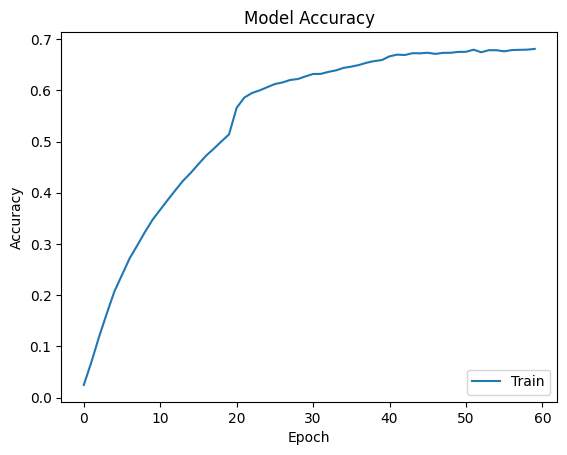

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()